In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
#img_rows, img_cols, img_chns = 8, 8, 3
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
num_sample = 60000

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 16))
epochs = int(os.environ.get('EPOCHS', 1000))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 5))

# Extract Test Image

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:num_sample, :img_rows, :img_cols, :img_chns].astype(float)
X_train_orig = X_train
y_train = y_train[:num_sample]

# add some random noise
#np.random.seed(0)
#X_train_processed = []
#for i in range(10):
#    for num, x in enumerate(X_train):
#        x = x.copy()
#        x += np.random.normal(0, 7)
#        X_train_processed.append(x.clip(0., 255.))
#        
#X_test = X_train
#X_train = np.array(X_train_processed)

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
#display(X_train_orig[0])
#display(X_train[0])
pass

In [5]:
#for i in range(min(num_sample * 10, len(X_train))):
#    plt.figure(figsize=(2, 2))
#    plt.imshow(X_train_orig[i % len(X_train_orig)] / 255.)
#    plt.show()
#    plt.figure(figsize=(2, 2))
#    plt.imshow(X_train[i] / 255.)
#    plt.show()

In [6]:
# Shift/scale to [-1, 1] interval
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Model

In [7]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def resnet_block(input_tensor, filters, stage, block, kernel=3):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (kernel, kernel), name=name_base + '_b-{}x{}'.format(kernel, kernel))
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x


def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for t in ['rb', 'gb', 'bb']:
        x = PixelConv2D(t, filters, kernel_size, 
                        name='final' + name + '_' + t,
                        padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    x = input_tensor
    for t in ['rb', 'gb', 'bb']:
        # Only allow things behind it...
        decoder_out_m = PixelConv2D(t, name='x_m' + str(t),
                                    filters=mixture_components,
                                    kernel_size=1,
                                    strides=1)(x)
        decoder_out_invs = PixelConv2D(t, name='x_s' + str(t),
                                        filters=mixture_components,
                                        kernel_size=1,
                                        strides=1,
                                        activation='softplus')(x)
        #decoder_out_invs = Lambda(lambda x: 4.0 * x)(decoder_out_invs_)
        mixture_weights = PixelConv2D(t, name='weights' + str(t),
                                      filters=mixture_components,
                                      kernel_size=1,
                                      strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [8]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (5, 5), name='conv1', is_first=True)

resnet_depth = 5
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a', kernel=3)
    
resnet_depth = 5
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage + 5, 'a', kernel=3)
    
resnet_depth = 5
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage + 10, 'a', kernel=3)

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.002)
#optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 32, 32, 256)  19456       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 32, 32, 256)  19456       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 32, 32, 256)  19456       main_input[0][0]                 
_________________________________________

In [9]:
early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=50.0, patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
filepath='./checkpoints/model-weights-2019-05-30.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, 
                                             mode='auto', period=10)

#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-05-13/' + str(int(time.time() % 10000)),
#                                          histogram_freq=1, batch_size=1,
#                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=1000,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],#, checkpoint],#, tensorboard],
    validation_data=(X_test, X_test),
    verbose=0
)

KeyboardInterrupt: 

In [15]:
#history = model.history
#history

,val_loss,loss,lr
count,27.000000,27.000000,27.000000
mean,10765.845021,10841.652838,0.000898
std,434.439146,565.252318,0.000764
min,10425.242539,10435.324504,0.000250
0%,10425.242539,10435.324504,0.000250
25%,10460.958449,10470.320857,0.000250
50%,10542.767880,10594.843465,0.000500
75%,10982.036230,11112.249804,0.002000
95%,11715.278128,11676.719832,0.002000
99%,11912.164643,12637.773490,0.002000


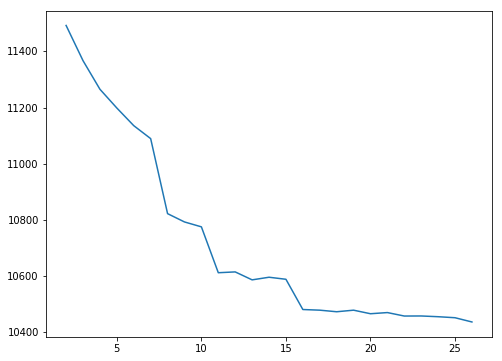

In [17]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
col = 'val_loss' if 'val_loss' in df else 'loss'
df['loss'][-25:].plot(figsize=(8, 6))

In [ ]:
#model.load_weights(filepath)
#model.compile(optimizer=optimizer, 
#              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

In [21]:
debug = False

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    
                    offset = mixture_components * img_chns + k * mixture_components
                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 3 and 0 <= j <= 3 and n == 0 and debug:
                        print("====", i, j, k)
                        print("X_train[0/1", i, j, k, "] = ", X_train[0, i, j, k], ', ', X_train[1, i, j, k], 
                              " (%s, %s)" % (X_train[0, i, j, k] * 127.5 + 127.5, X_train[1, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        #if debug:
        print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


In [22]:
#%lprun -f compute_mixture gen_image(model, 2)

(128, 128, 3)
row 0
row 1
row 2
row 3
row 4
row 5
row 6
row 7
row 8
row 9
row 10
row 11
row 12
row 13
row 14
row 15
row 16
row 17
row 18
row 19
row 20
row 21
row 22
row 23
row 24
row 25
row 26
row 27
row 28
row 29
row 30
row 31


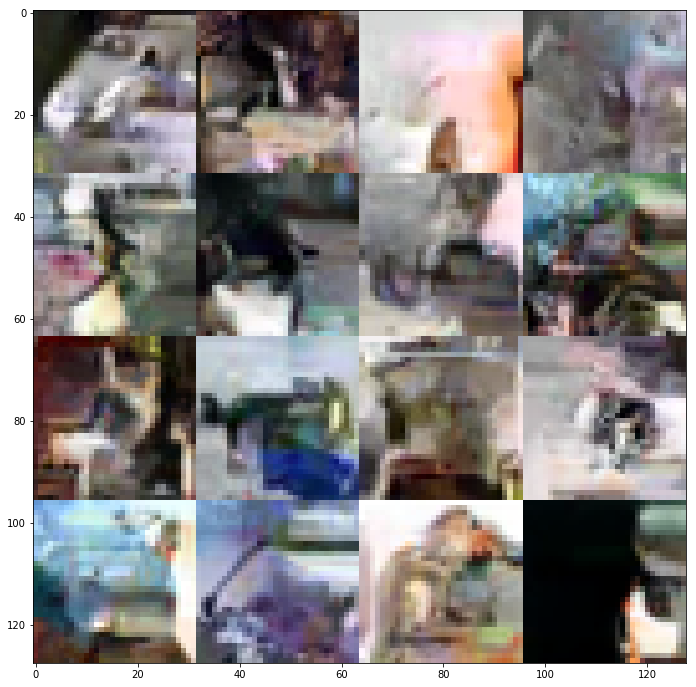

Elapsed:  2176.507438659668


In [36]:
start = time.time()

n = 1 if debug else batch_size
num_samples = min(n, batch_size)
rows = int(n // np.ceil(np.sqrt(num_samples)))
cols = int(n // np.ceil(np.sqrt(num_samples)))

figure = np.zeros((img_rows * rows, img_cols * cols, img_chns))
print(figure.shape)
samples = gen_image(model, num_samples=num_samples)
for i in range(rows):
    for j in range(cols):
        img = samples[i * rows + j] / 255.
        d_x = (i * img_rows)
        d_y = (j * img_cols)
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [ ]:
for i in range(num_sample):
    plt.figure(figsize=(2, 2))
    plt.imshow((X_train[i] * 127.5 + 127.5) / 255.)
    plt.show()

plt.figure(figsize=(6, 4))
plt.imshow(figure[:32,:64])
plt.show()

# 2019-06-03

* I *think* I fixed the loss function in two ways:
  * I updated the offset for the exception and normal case, should be correct now
  * I think I was doing an extra `K.sum()` at the end of the loss function, essentially summing up the entire batch's loss vs. just summing each item's loss.  Keras probably takes a `mean` at the end over the batch dimension, so probably no need to do a `sum`.  After this change, the reported loss looks more normal with los bits/pixel.
* Right now, I'm trying smaller examples 4x4 with 2 images using 5 mixture components, I get some funky results, still need to experiment a bit more.  Although, before the `sum` change above, I did get something that looked kind of reasonable.  So it's probably just a bad run, too many mixture components, or maybe the `sum` change is weird.

TODO: Play around a bit more, change mixture components, see if I can get an image that looks reasonable.

# 2019-06-08

* Sped up the image generation, don't use `scipy.logistic.cdf`, it's too slow.  Instead just use `sigmoid` directly.
  * Had to add an exception case to `sigmoid` prevent overflow.
* It looks like the network is not properly distinguishing between the two images, it looks like it learns certain local parts but doesn't separate them when generating a new image. Wonder why that's happening?
* Tried 9x9 convolution at beginning but still no dice.  Some ideas:
  * Might be overfiting?  Althought seems unlikely... bits/pixel is low-ish but even when it was higher it didn't have the same problems
  * Could be the adjustment I made on the loss function (to fix the exception case)?
  * Some other reason???


# 2019-06-27

* Tried using image augementation to prevent overfitting and using the original images as the test set
    * Validation loss definitely plateaus earlier than when I was using just training loss directly
    * Image looks crazy, I get some mishmash of all the images together.  For some reason, it's not learning long range dependencies.  Maybe I need to make the filter size bigger?  Not quite sure.
* Tried a bigger filter size and at least it looks like it's not mixing the two images (at 9x9 and 5x5), going to try (11x11 and 7x7)

# 2019-07-02

* Tried differing resolutions of kernel size (7x7, 5x5, 3x3) as you move through the ResNet filters, kind of looks a bit better?
* Also tried reducing number of components
* **PROBLEM**: One concerning point is that I never see a bi-modal distribution.  Shouldn't I see one?  These two samples have very different starting pixels (one is dark (40-60s), the other is light (150s)), should I see at least a bi-modal distribution?  Need to investigate - maybe shrink image first to speed up training.

# 2019-07-03

* Removed the `5 * x + 3` lambda, doesn't look like it was needed
* Took a closer look at the images genenerated by PixelCNN and they are crazy! No coherence, just a mishmash of stuff, no global structure!  So so long as I can get a small loss, I think I'm on the right track!
* I will say that the first pixel doesn't get estimated correctly.  It's almost always unimodal, when it's clear that it should be bi-modal.  This might indicate that the network doesn't have enough capacity (or just can't figure out how to model this properly).
    * However, when you do a small image (e.g. 2x2), it can correctly get a bimodel distribution for it.
    * So there is something there about getting it right but when you have a big image, the conv layer probably can't capture every single pixel properly, it likely just prioritizes the "important" ones which are probably not on the edge.

# 2019-07-06

* Trying some variations to run on the entire 50k CIFAR-10 dataset
* Training is slow ~ 40min/epoch 
* Trying to increase learning rate but at 0.05+ I get into NaN territory
* Started modifying `invs' = 0.1 * invs` to make the gradient on that variable smaller (we use `exp(invs)` in the loss function which explodes the loss if our learning rate is too high).
  * Using this, I can set learning rate at `0.4`
  * So far, the loss starts at a higher level (20k) and is decreasing at a decent clip.  Let's see if it keeps on going lower.
  * I think this may in fact be better.  We want the `invs` to change slowly, while we want more freedome to move the `\mu`.  
  * If you look at the derivatives of `(x-\mu)e^invs` vs `(x-\mu)e^(0.1*invs)`, we see that the gradient of `\mu` is similar (with respect to the `invs'`) but the gradient on `invs` is `0.1` smaller.
  * Let's see what happens.
* Actually, now I'm *multiplying* `invs' = b * invs` to make it train faster!  At least in the first few minutes, we have faster decline... let's see.  (This is kind of what I saw when I was doing single images.)
  * Nevermind, it looks like it slowed down a bit.
  * Just going to go back to no multiplication.